In [1]:
import os
from pathlib import Path

def root_dir(marker="EXPLib"):
    cwd = Path.cwd()
    # if cwd already contains the marker
    if (cwd / marker).is_dir():
        return cwd
    # otherwise walk up the parents
    for p in cwd.parents:
        if (p / marker).is_dir():
            return p
    raise FileNotFoundError(f"Root marker '{marker}' not found")

os.chdir(root_dir())
# print(os.getcwd())


In [3]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from EXPLib.xai_library.data_explainers.data_descriptors import vae_descriptor

In [ ]:
# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define local dataset folder
dataset_folder = './EXPLib/datasets/Camera/toy_model_v1_inference/dev/images'
saved_model_folder = './EXPLib/dl_component/AEs/VAE/weight'
model_name = 'vae_model20240617_toy_dev_img.pth'
SAVED_MU_LATENT = './EXPLib/datasets/Camera/toy_model_v1_inference/vae_latents/mu_array_toydataset.npy'
test_img_folder = './EXPLib/datasets/Camera/test_images'
test_image='rgb_0000079_modified.png'

resized_width = 160
resized_height = 160
latent_dim = 256

In [7]:
model_path = os.path.join(saved_model_folder, model_name)

vae_model = vae_descriptor.VAE(input_shape=(3, resized_height, resized_width), latent_dim=latent_dim).to(device)
vae_model = vae_descriptor.load_vae_model(vae_model, model_path, device)

reconstructed_image, anomaly_score = vae_descriptor.detect_anomaly(vae_model, os.path.join(test_img_folder, test_image))

mu_array = np.load(SAVED_MU_LATENT)

In [8]:
pca = PCA(n_components=15)
pca.fit(mu_array)
eigenvectors = pca.components_
eigenvalues = pca.explained_variance_

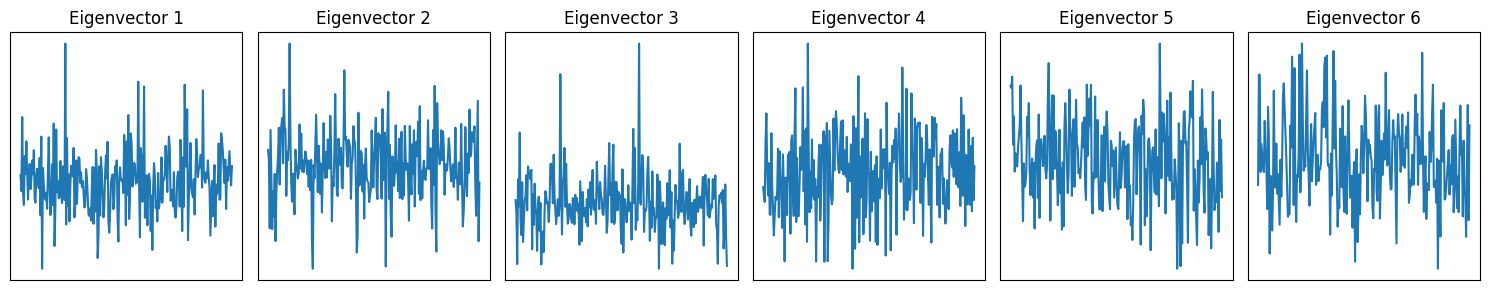

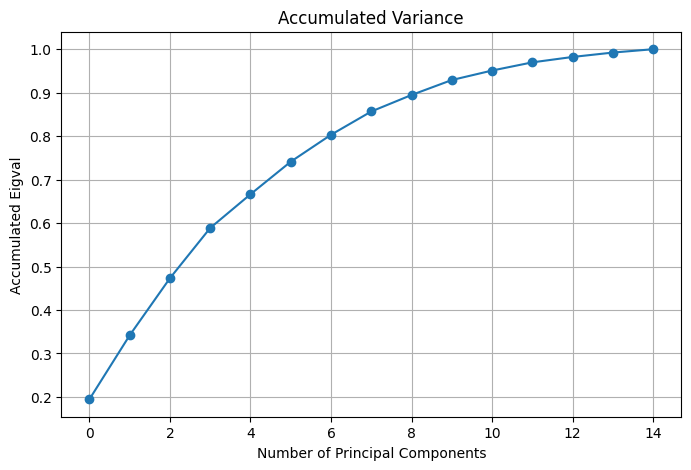

In [9]:
accumulated_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)
num_vectors = 6  
fig, axes = plt.subplots(1, num_vectors, figsize=(15, 3))

for i in range(num_vectors):
    axes[i].plot(eigenvectors[i])  
    axes[i].set_title(f"Eigenvector {i+1}")
    axes[i].set_xticks([])
    axes[i].set_yticks([])

plt.tight_layout()
plt.show()

# Plot accumulated eigenvalues
plt.figure(figsize=(8, 5))
plt.plot(accumulated_variance[:15], marker="o", linestyle="-")
plt.xlabel("Number of Principal Components")
plt.ylabel("Accumulated Eigval")
plt.title("Accumulated Variance")
plt.grid()
plt.show()


In [10]:
def compute_reconstruction_error(input_vector, pca_basis):
    """
    Computes the reconstruction error of an input vector using the first 15 PCA eigenvectors.
    
    Parameters:
        input_vector (np.array): A (256,) dimensional input vector.
        pca_basis (np.array): A (15, 256) matrix containing the first 15 eigenvectors.

    Returns:
        float: The Euclidean reconstruction error.
    """
    input_vector = input_vector.reshape(1, -1)  # Ensure row vector (1, 256)
    
    # Project onto the PCA basis (coefficients in 15D space)
    projected_coeffs = input_vector @ pca_basis.T  # (1, 256) @ (15, 256).T → (1, 15)
    
    # Reconstruct the vector in the original 256D space
    reconstructed = projected_coeffs @ pca_basis  # (1, 15) @ (15, 256) → (1, 256)
    
    # Compute reconstruction error (Euclidean distance)
    error = np.linalg.norm(input_vector - reconstructed)  # || original - reconstructed ||
    
    return error


In [11]:
test_vector = np.random.rand(256) # This would be mu_vector extracted from the VAE for a new input image

compute_reconstruction_error(test_vector, eigenvectors) # This would show the anomaly score from latent space

np.float64(8.838566592257743)

In [12]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

def compute_anomaly_heatmap(vae, eigenbasis, image_path, resized_height=160, resized_width=160):
    """
    Compute an anomaly heatmap using the VAE and eigenbasis of latent space.
    
    Args:
        vae (VAE): Trained VAE model.
        eigenbasis (np.ndarray or torch.Tensor): (latent_dim x k) eigenbasis.
        image_path (str): Path to input image.
        resized_height (int): Height to resize the image.
        resized_width (int): Width to resize the image.

    Returns:
        heatmap_np (np.array): Normalized anomaly heatmap.
    """
    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((resized_height, resized_width)),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert("RGB")
    
    # Get device from model
    device = next(vae.parameters()).device

    # Convert eigenbasis to tensor and move to device
    if isinstance(eigenbasis, np.ndarray):
        eigenbasis = torch.tensor(eigenbasis, dtype=torch.float32)
    eigenbasis = eigenbasis.to(device)

    # Convert image to tensor and move to device
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Forward pass to get mu and logvar
    with torch.no_grad():
        recon_orig, mu, logvar = vae(image_tensor)  # Get reconstructed image, mu, and logvar

    # Ensure mu is on the correct device
    mu = mu.squeeze(0)  # Remove batch dimension (shape: [latent_dim])
    
    # Project mu onto lower-dimensional eigenbasis
    mu_proj = eigenbasis @ (eigenbasis.T @ mu)  # Projection (latent_dim,)

    # Decode from mu_proj
    with torch.no_grad():
        recon_proj = vae.decoder(mu_proj.unsqueeze(0))  # Shape: (1, C, H, W)

    # Compute per-pixel reconstruction error (L2 norm)
    recon_error = (image_tensor - recon_proj) ** 2  # Squared error
    heatmap = recon_error.mean(dim=1).squeeze(0)  # Mean over channels, remove batch dimension

    # Normalize heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # Convert heatmap to numpy
    heatmap_np = heatmap.cpu().numpy()

    return heatmap_np


def visualize_anomaly(image_path, heatmap):
    """
    Overlay anomaly heatmap on original image.
    
    Args:
        image_path (str): Path to the original image.
        heatmap (np.array): Anomaly heatmap (H, W).
    """
    # Load original image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize heatmap to match image
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    
    # Convert heatmap to color
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Overlay heatmap on original image
    overlay = cv2.addWeighted(image, 0.6, heatmap_colored, 0.4, 0)

    # Show results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_colored)
    plt.title("Anomaly Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")

    plt.show()


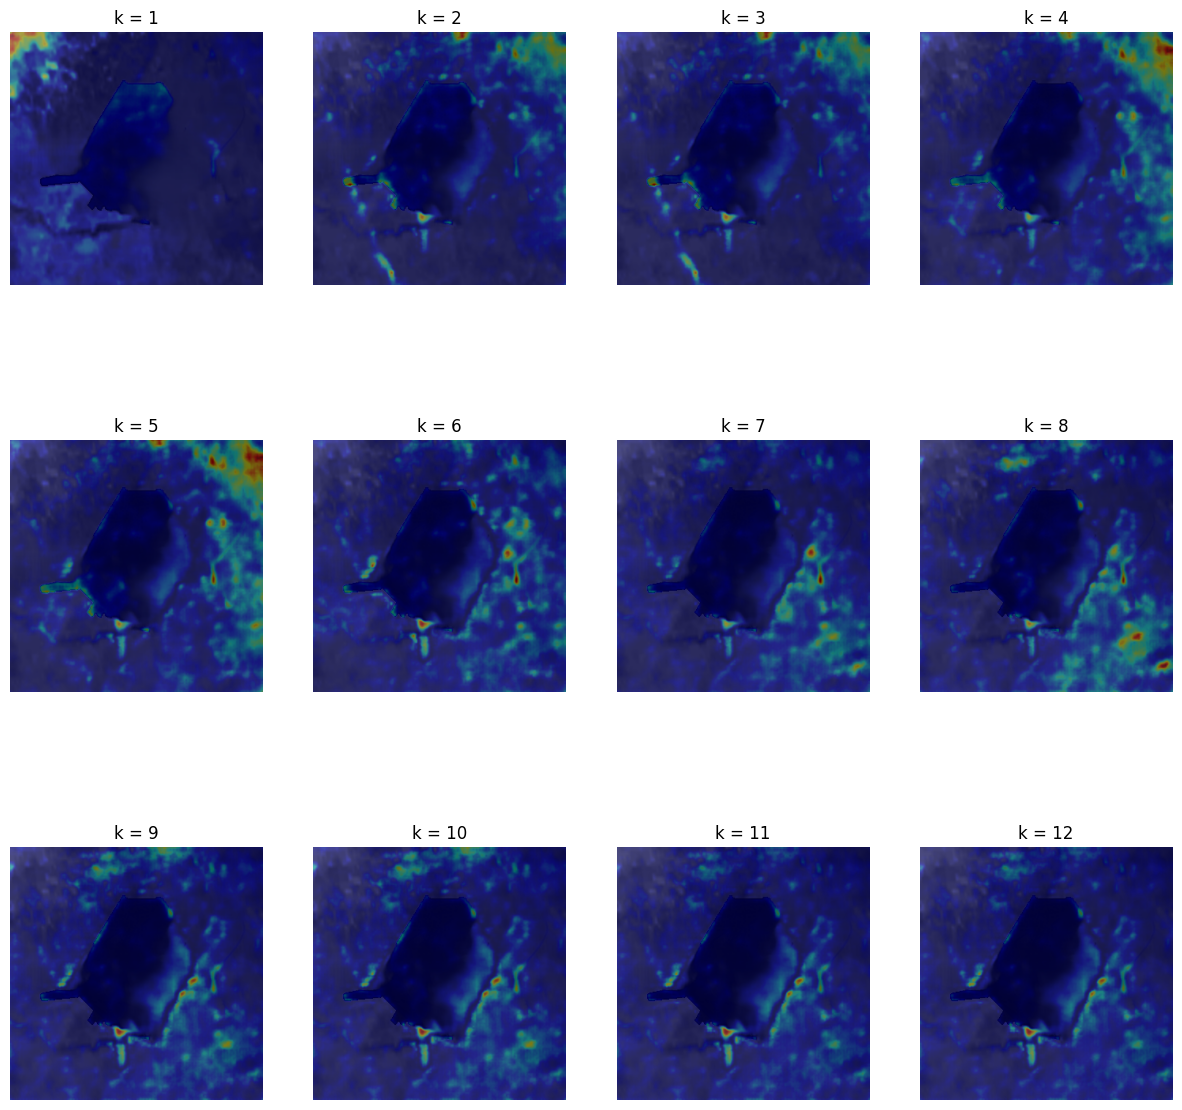

In [13]:
test_image='rgb_0000079_modified2.png'

max_k = 12  # Maximum number of eigenbasis vectors to test

heatmaps = []
ks = []

for k in range(1, max_k + 1):  
    eigenbasis_k = eigenvectors[:k, :].T  # Select first k eigenvectors
    heatmap = compute_anomaly_heatmap(vae_model, eigenbasis_k, os.path.join(test_img_folder, test_image))
    heatmaps.append(heatmap)
    ks.append(k)

def visualize_anomaly_multi(image_path, heatmaps, ks):
    """
    Overlay multiple anomaly heatmaps for increasing eigenbasis dimensions.

    Args:
        image_path (str): Path to the original image.
        heatmaps (list of np.array): List of anomaly heatmaps.
        ks (list of int): List of eigenbasis dimensions used.
    """
    # Load original image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Number of heatmaps
    num_heatmaps = len(heatmaps)

    num_cols = min(4, len(heatmaps))  # Max 4 columns
    num_rows = (len(heatmaps) + num_cols - 1) // num_cols  # Compute number of rows

    plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure size dynamically

    for i, (heatmap, k) in enumerate(zip(heatmaps, ks)):
        heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

        # Overlay heatmap on original image
        overlay = cv2.addWeighted(image, 0.6, heatmap_colored, 0.4, 0)

        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(overlay)
        plt.title(f"k = {k}")
        plt.axis("off")

    plt.show()

visualize_anomaly_multi(os.path.join(test_img_folder, test_image), heatmaps, ks)

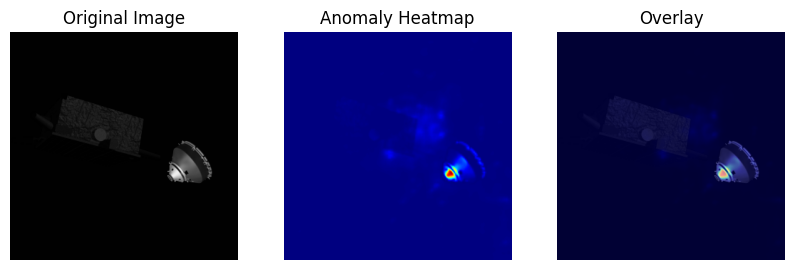

In [14]:
ufo_folder = './EXPLib/datasets/Camera/250127-toymodel_dataset_ufo/dataset_ufo_1000'
test_image = 'rgb_0134.png'

heatmap = compute_anomaly_heatmap(vae_model,eigenvectors[:2,:].T, os.path.join(ufo_folder, test_image))
visualize_anomaly(os.path.join(ufo_folder, test_image), heatmap)